In [1]:
from typing import Iterable, Union

import matplotlib.pyplot as plt
import torch
import pandas as pd
import torch.nn as nn
from torch.utils import data
import numpy as np

import os

In [2]:
DATA_DIR = '/Users/aplle/Code/MathModeling/SC/dataset1'
MODEL_DIR = '/Users/aplle/Code/MathModeling/SC/models'
PLOT_DIR = '/Users/aplle/Code/MathModeling/SC/plots'

In [26]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
eval_df = pd.read_csv(f"{DATA_DIR}/eval.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

POWER_DIVISOR = 1000.0
YEAR_MIN = 2016
YEAR_MAX = 2018

def is_leap(yr:int):
    if yr % 400 == 0:
        return True
    elif yr % 100 == 0:
        return False
    elif yr % 4 == 0:
        return True
    return False

def get_ndays(yr:int):
    return 366 if is_leap(yr) else 365

def preprocess_df(df):
    df.dropna(subset=['Power (kW)'], inplace=True)
    df['Power (kW)'] = df['Power (kW)'] / POWER_DIVISOR
    df.rename(columns={'Power (kW)': 'Power'}, inplace=True)

    df['Days_from_NYD'] = df['Days_from_NYD'] / df['Year'].apply(get_ndays)

    df['Year'] = df['Year'] - YEAR_MIN
    df['Year'] = df['Year'] / (YEAR_MAX - YEAR_MIN)

    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
    df['Time'] = df['Time'].dt.hour * 60 + df['Time'].dt.minute
    df['Time'] = df['Time'] / (24 * 60)

    df.drop(['Day', 'Span'], axis=1, inplace=True)

    df['Month'] = df['Month'] / 12.0

    df['Weekday'] = df['Weekday'] / 6.0

    df['Region'] = df['Region'].map({
        'Commercial': 0,
        'Office': 1,
        'Public': 2,
        'Residential': 3
    })

    return df

train_df = preprocess_df(train_df)
_train_columns = train_df.columns.copy()

eval_df = preprocess_df(eval_df)
eval_df = eval_df.reindex(columns=_train_columns, fill_value=0)

test_df = preprocess_df(test_df)
test_df = test_df.reindex(columns=_train_columns, fill_value=0)


In [28]:
test_df

,Time,Power,Year,Month,Weekday,Region,Days_from_NYD
0,0.000000,0.88704,1.0,0.75,0.833333,0,0.665753
1,0.003472,0.88821,1.0,0.75,0.833333,0,0.665753
2,0.006944,0.86266,1.0,0.75,0.833333,0,0.665753
3,0.010417,0.87131,1.0,0.75,0.833333,0,0.665753
4,0.013889,0.83178,1.0,0.75,0.833333,0,0.665753
...,...,...,...,...,...,...,...
141027,0.986111,0.20560,1.0,1.00,0.000000,2,0.997260
141028,0.989583,0.17880,1.0,1.00,0.000000,2,0.997260
141029,0.993056,0.18240,1.0,1.00,0.000000,2,0.997260
141030,0.996528,0.18640,1.0,1.00,0.000000,2,0.997260


In [5]:
class PowerTCNDataset(data.Dataset):
    def __init__(self, df, hist_len, time_cols):
        self.hist_len = hist_len
        self.time_cols = time_cols

        self.x_hist = []
        self.x_time = []
        self.x_loc = []
        self.y = []

        for loc, g in df.groupby("Region"):
            g:pd.DataFrame = g.reset_index(drop=True)

            power = g["Power"].to_numpy().astype(np.float32)
            time_feat = g[time_cols].to_numpy().astype(np.float32)

            for t in range(hist_len, len(g)):
                self.x_hist.append(power[t - hist_len:t])  # X_hist
                self.x_time.append(time_feat[t])           # X_time
                self.x_loc.append(loc)                      # X_loc
                self.y.append(power[t])                     # y

        self.x_hist = torch.tensor(np.array(self.x_hist))
        self.x_time = torch.tensor(np.array(self.x_time))
        self.x_loc = torch.tensor(np.array(self.x_loc), dtype=torch.long)
        self.y = torch.tensor(np.array(self.y))

    def __len__(self):
        return self.x_loc.shape[0]

    def __getitem__(self, idx):
        return (
            self.x_hist[idx].unsqueeze(0),  # [1, k]
            self.x_time[idx],             # [d_time]
            self.x_loc[idx],
            self.y[idx]
        )

In [6]:
HIST_LEN = 288
TIME_COLS = [
    "Time",
    "Year",
    "Month",
    "Weekday",
    "Days_from_NYD"
]

train_ds = PowerTCNDataset(train_df, HIST_LEN, TIME_COLS)
eval_ds = PowerTCNDataset(eval_df, HIST_LEN, TIME_COLS)
# test_ds = PowerTCNDataset(test_df, HIST_LEN, TIME_COLS)

train_loader = data.DataLoader(train_ds, batch_size=128, shuffle=True)
eval_loader = data.DataLoader(eval_ds, batch_size=128, shuffle=False)
# test_loader = data.DataLoader(test_ds, batch_size=1, shuffle=False)

In [7]:
from torch.nn.utils.parametrizations import weight_norm

class TCNBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = weight_norm(
            nn.Conv1d(in_ch, out_ch, kernel_size,
                      padding=padding, dilation=dilation)
        )
        self.conv2 = weight_norm(
            nn.Conv1d(out_ch, out_ch, kernel_size,
                      padding=padding, dilation=dilation)
        )

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_ch, out_ch, 1)
            if in_ch != out_ch else None
        )

    def forward(self, x):
        out = self.conv1(x)
        out = out[..., :-self.conv1.padding[0]]  # causal crop
        out = self.relu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = out[..., :-self.conv2.padding[0]]
        out = self.relu(out)
        out = self.dropout(out)

        res = x if self.downsample is None else self.downsample(x)
        return out + res

In [8]:
class PowerTCN(nn.Module):
    def __init__(
        self,
        hist_len,
        time_dim,
        num_locations=4,
        loc_emb_dim=6,
        channels=64,
        layers=7,
        kernel_size=3,
        dropout=0.1,
    ):
        super().__init__()

        blocks = []
        in_ch = 1
        for i in range(layers):
            blocks.append(
                TCNBlock(
                    in_ch, channels,
                    kernel_size,
                    dilation=2 ** i,
                    dropout=dropout
                )
            )
            in_ch = channels

        self.tcn = nn.Sequential(*blocks)
        self.loc_emb = nn.Embedding(num_locations, loc_emb_dim)

        self.mlp = nn.Sequential(
            nn.Linear(channels + time_dim + loc_emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x_hist, x_time, x_loc):
        """
        x_hist: [B, 1, k]
        x_time: [B, d_time]
        x_loc : [B]
        """
        h = self.tcn(x_hist)          # [B, C, k]
        h = h[:, :, -1]               # [B, C]

        loc = self.loc_emb(x_loc)     # [B, loc_emb_dim]

        z = torch.cat([h, x_time, loc], dim=1)
        return self.mlp(z).squeeze(1)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = PowerTCN(
    hist_len=HIST_LEN,
    time_dim=len(TIME_COLS)
).to(device)


In [10]:
def train_epoch(loader, opt, loss_fn, train=True):
    model.train() if train else model.eval()
    total_loss = 0

    with torch.set_grad_enabled(train):
        for x_hist, x_time, x_loc, y in loader:
            x_hist = x_hist.to(device)
            x_time = x_time.to(device)
            x_loc  = x_loc.to(device)
            y      = y.to(device)

            pred = model(x_hist, x_time, x_loc)
            l = loss_fn(pred, y)

            if train:
                opt.zero_grad()
                l.backward()
                opt.step()

            total_loss += l.item() * len(y)

    return total_loss / len(loader.dataset)


In [11]:
import torch.optim as optim

def train(model, train_loader, eval_loader, epochs=50, lr=1e-3, weight_decay=1e-4, checkpoint_path="best_tcn.pt"):
    best_eval = float("inf")

    opt = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    loss_fn = nn.HuberLoss(delta=1.0)

    for epoch in range(epochs):
        train_loss = train_epoch(train_loader, opt, loss_fn, train=True)
        eval_loss   = train_epoch(eval_loader, opt, loss_fn, train=False)

        print(f"Epoch {epoch:03d} | train {train_loss:.4f} | val {eval_loss:.4f}")

        if eval_loss < best_eval:
            best_eval = eval_loss
            if checkpoint_path is not None:
                try:
                    torch.save(model.state_dict(), os.path.join(MODEL_DIR, checkpoint_path))
                except Exception:
                    pass


In [12]:
train(model, train_loader, eval_loader)

Epoch 000 | train 0.0006 | val 0.0014
Epoch 001 | train 0.0003 | val 0.0011
Epoch 002 | train 0.0003 | val 0.0011
Epoch 003 | train 0.0003 | val 0.0013
Epoch 004 | train 0.0003 | val 0.0011
Epoch 005 | train 0.0003 | val 0.0013
Epoch 006 | train 0.0003 | val 0.0011
Epoch 007 | train 0.0002 | val 0.0013
Epoch 008 | train 0.0002 | val 0.0010
Epoch 009 | train 0.0002 | val 0.0012
Epoch 010 | train 0.0002 | val 0.0009
Epoch 011 | train 0.0002 | val 0.0011
Epoch 012 | train 0.0002 | val 0.0012
Epoch 013 | train 0.0002 | val 0.0014
Epoch 014 | train 0.0002 | val 0.0010


KeyboardInterrupt: 

In [30]:
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, 'tcn_14e.pt'), map_location=device))

<All keys matched successfully>

In [37]:
from typing import Union, Iterable

def predict(model, x_hist, x_time, x_loc, extrapolate_steps=0):
    for o in [x_hist, x_time, x_loc]:
        o.unsqueeze_(0)

    with torch.no_grad():
        while extrapolate_steps >= 0:
            pred = model(x_hist, x_time, x_loc)  # [1]
            # append pred to x_hist
            x_hist = torch.cat([x_hist[:, :, 1:], pred.unsqueeze(0).unsqueeze(0)], dim=2)
            x_time += 1 / 288
            extrapolate_steps -= 1

        return pred.item()*POWER_DIVISOR

def predict_with_test(df: pd.DataFrame, idx = HIST_LEN*10):
    if idx >= len(df):
        print('Using Extrapolation')
        ext = idx - (len(df) - 1)
        idx = len(df) - 1
    else:
        ext = 0

    x_hist = df['Power'][idx - HIST_LEN:idx]
    x_time = df[TIME_COLS].iloc[idx]
    x_loc = df['Region'].iloc[idx]
    y = df['Power'].iloc[idx]

    x_hist = torch.tensor(x_hist.to_numpy().astype(np.float32)).to(device).unsqueeze(0)
    x_time = torch.tensor(x_time.to_numpy().astype(np.float32)).to(device)
    x_loc = torch.tensor(x_loc, dtype=torch.long).to(device)

    return predict(model, x_hist, x_time, x_loc, extrapolate_steps=ext), y*POWER_DIVISOR

def predict_with_importance(df: pd.DataFrame, idx = HIST_LEN*10):
    if idx >= len(df):
        print('Out of bounds')
        return
    x_hist = df['Power'][idx - HIST_LEN:idx]
    x_time = df[TIME_COLS].iloc[idx]
    x_loc = df['Region'].iloc[idx]

    x_hist = torch.tensor(x_hist.to_numpy().astype(np.float32)).to(device).unsqueeze(0)
    x_time = torch.tensor(x_time.to_numpy().astype(np.float32)).to(device)
    x_loc = torch.tensor(x_loc, dtype=torch.long).to(device)

    for o in [x_hist, x_time, x_loc]:
        o.unsqueeze_(0)

    x_hist.requires_grad_(True)

    pred = model(x_hist, x_time, x_loc)
    pred.backward()
    importance = x_hist.grad * x_hist

    return importance

def predict_with_residual(df: pd.DataFrame, idx: Union[int, Iterable[int]] = HIST_LEN * 10):
    ret = []
    with torch.no_grad():
        saved = model.loc_emb.weight.data.clone()
        model.loc_emb.weight.data.zero_()

        if isinstance(idx, int):
            idx = [idx]

        for i in idx:
            y_hat, y_true = predict_with_test(df, i)
            residual = y_true - y_hat
            ret.append(residual)

        model.loc_emb.weight.data.copy_(saved)

    ret = np.array(ret)
    return ret

In [ ]:
g = test_df.groupby("Region")
for region, df in g:
    results =[]
    print(f"Predicting for Region {region}")
    df = df.reset_index(drop=True).drop_na()
    for i in range(HIST_LEN, len(df)):
        results.append(predict_with_test(df, i))

    print(results[:10])
    result_df = pd.DataFrame(results, columns=['Predicted Power (kW)', 'True Power (kW)'])
    result_df.to_csv(os.path.join(MODEL_DIR, f'tcn_results_region_{region}.csv'), index=False)

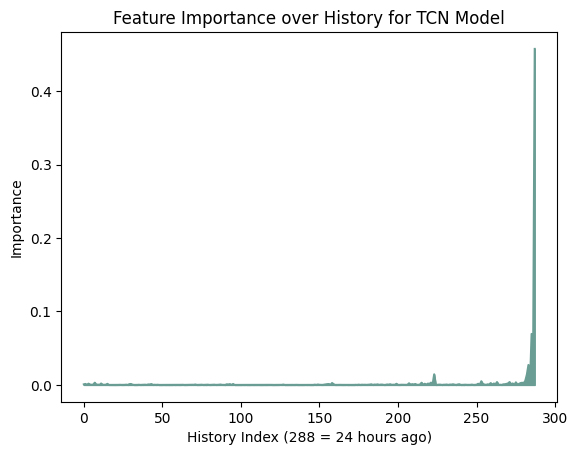

In [38]:
ipt = predict_with_importance(test_df, HIST_LEN*10)
ipt = ipt.abs().squeeze().detach().numpy()

from matplotlib import pyplot as plt

plt.plot(range(ipt.shape[0]), ipt, color='#6A9E94')
plt.fill_between(range(ipt.shape[0]), ipt, 0, color='#6A9E94', alpha=1)
plt.xlabel('History Index (288 = 24 hours ago)')
plt.ylabel('Importance')
plt.title('Feature Importance over History for TCN Model')
plt.savefig(os.path.join(PLOT_DIR, 'tcn_feature_importance.png'), dpi=300)
plt.show()
# ipt

In [ ]:
result_df = pd.DataFrame(results, columns=['Predicted Power (kW)', 'True Power (kW)'])
result_df.to_csv(os.path.join(MODEL_DIR, 'tcn_results.csv'), index=False)

In [31]:
predict_with_test(test_df, len(test_df)-30000)

(422.15320467948914, 440.22)

In [56]:
torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'tcn_14e.pt'))

In [38]:
model.modules()

<bound method Module.modules of PowerTCN(
  (tcn): Sequential(
    (0): TCNBlock(
      (conv1): ParametrizedConv1d(
        1, 64, kernel_size=(3,), stride=(1,), padding=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (conv2): ParametrizedConv1d(
        64, 64, kernel_size=(3,), stride=(1,), padding=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (relu): ReLU()
      (dropout): Dropout(p=0.1, inplace=False)
      (downsample): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
    )
    (1): TCNBlock(
      (conv1): ParametrizedConv1d(
        64, 64, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (conv2): ParametrizedConv1d(


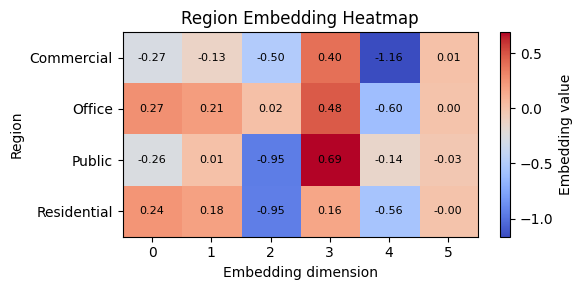

In [19]:
import matplotlib.pyplot as plt

emb = model.loc_emb.weight.detach().numpy()

region_names = ['Commercial', 'Office', 'Public', 'Residential']

fig, ax = plt.subplots(figsize=(6, 3))

im = ax.imshow(
    emb,
    aspect="auto",
    cmap="coolwarm"
)

# 坐标轴
ax.set_xticks(np.arange(emb.shape[1]))
ax.set_yticks(np.arange(len(region_names)))
ax.set_yticklabels(region_names)

ax.set_xlabel("Embedding dimension")
ax.set_ylabel("Region")
ax.set_title("Region Embedding Heatmap")

# 颜色条
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Embedding value")

for i in range(len(region_names)):
    for j in range(emb.shape[1]):
        ax.text(
            j, i,
            f"{emb[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=8,
            color="black"
        )


plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, 'tcn_heatmap.png'), dpi=300)
plt.show()


In [21]:
test_df[:10]

,Time,Power,Year,Month,Weekday,Region,Days_from_NYD
0,0.000000,0.88704,1.0,0.75,0.833333,0,0.665753
1,0.003472,0.88821,1.0,0.75,0.833333,0,0.665753
2,0.006944,0.86266,1.0,0.75,0.833333,0,0.665753
3,0.010417,0.87131,1.0,0.75,0.833333,0,0.665753
4,0.013889,0.83178,1.0,0.75,0.833333,0,0.665753
5,0.017361,0.83518,1.0,0.75,0.833333,0,0.665753
6,0.020833,0.83859,1.0,0.75,0.833333,0,0.665753
7,0.024306,0.82555,1.0,0.75,0.833333,0,0.665753
8,0.027778,0.81268,1.0,0.75,0.833333,0,0.665753
9,0.031250,0.80150,1.0,0.75,0.833333,0,0.665753


In [22]:
model.loc_emb.weight.data.zero_()

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])

In [70]:
g = test_df.groupby("Region")
results = []
for region, df in g:
    df = df[:3000]
    df = df.reset_index(drop=True)
    # print(df)
    res = predict_with_residual(df, range(HIST_LEN, len(df)))
    res = np.concatenate([np.zeros(HIST_LEN),res], axis=0)
    res = pd.DataFrame(res, columns=[f'{region_names[region]}'])
    df = pd.concat([df, res], axis=1, ignore_index=False)
    # print(df)
    df = df.groupby(['Year', 'Month', 'Weekday', 'Time']).last()
    df.drop(columns=['Region', 'Power', 'Days_from_NYD'], inplace=True)
    results.append(df)

final_results = pd.concat(results, axis=1)
final_results.corr()
# results

,Commercial,Office,Public,Residential
Commercial,1.000000,0.405128,0.371859,0.235674
Office,0.405128,1.000000,0.882887,0.649686
Public,0.371859,0.882887,1.000000,0.569076
Residential,0.235674,0.649686,0.569076,1.000000


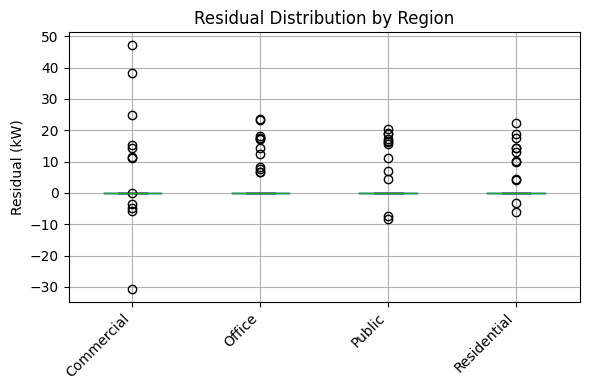

In [75]:
# draw a box plot of final_results
plt.figure(figsize=(6, 4))
final_results.boxplot()
plt.ylabel('Residual (kW)')
plt.title('Residual Distribution by Region')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

In [76]:
final_results.mean()

Commercial     0.392476
Office         0.578700
Public         0.437804
Residential    0.399365
dtype: float64

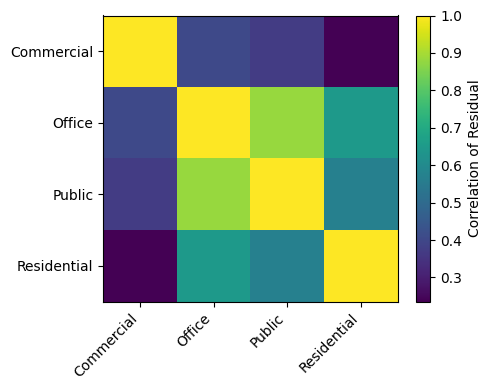

In [74]:
from matplotlib.colors import Normalize

corr = final_results.corr()

plt.figure(figsize=(5, 4))

# norm = Normalize(vmin=-1, vmax=1)

im = plt.imshow(
    corr.to_numpy(),
    aspect='auto',
    origin='upper'
    # norm=norm
)

plt.colorbar(im, label='Correlation of Residual')

plt.xticks(
    ticks=range(len(corr.index)),
    labels=corr.index,
    rotation=45,
    ha='right'
)

plt.yticks(
    ticks=range(len(corr.index)),
    labels=corr.index
)

# plt.xlabel('Month')
# plt.ylabel('Region')

plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, 'Month-plot.png'), dpi=300)
plt.show()
